# Assignment 2 - Security and Privacy of Machine Learning
### By Daan Brugmans (s1080742)

This notebook contains the implementation of Assignment 2 for the Radboud University course [Security and Privacy of Machine Learning](https://www.ru.nl/courseguides/science/vm/osirislinks/imc/nwi-imc069/).
The topic at hand is to execute, analyze, and defend against backdoor attacks on convolutional neural networks.
Specifically, this notebook wil look at [Blend Attacks](https://arxiv.org/pdf/1712.05526) and [WaNet Attacks](https://arxiv.org/pdf/2102.10369), in addition to the [Fine-Pruning Defense](https://arxiv.org/pdf/1805.12185).

This notebook is divided into two parts.
In the first part, we will set up and define all components that we need in order to answer the questions posed in the assignment.
In the second part, we will answer the questions in a Q&A-style by providing the question, the code that will give us an answer, and the answer itself.

This notebook should show all results without being needed to run.
However, if you do want to run this notebook, I have provided a `requirements.txt` that you can use to install all the required packages.
You can also find this notebook with [this URL](https://github.com/daanbrugmans/ru-security-and-privacy-of-machine-learning-23-24/blob/main/assignment-2/assignment-2.ipynb).

## Part 1: Setup

### 1.1 Imports
We will use PyTorch as the main environment for our deep learning endeavors. To this end, we will use the `torch` and `torchvision` packages.

In [12]:
import random
import gc
from copy import copy

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.utils.prune 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision

### 1.2 Preparation
Some preparatory code is performed here: we set a seed for `torch`, `numpy`, and `random` for reproducibility, and we set the device on which we will perform our model training. We also define a function for visualizing a batch of images, so that we can visually check if a backdoor has been executed successfully.

In [2]:
def visualize_batch(images: torch.Tensor, labels: torch.Tensor):
    """Visualizes a batch of images.
    
    Taken from week 9 notebook (Backdoor Defenses, dr. Picek) and refactored."""
    
    # Making sure we can view the images
    images = images.detach().numpy()
    images = images*255
    images = [image.astype(np.uint8) for image in images]
    images = [np.moveaxis(image, source=0, destination=-1) for image in images]
    
    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx], cmap='viridis')
        # Print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
    
    plt.show()

def set_global_seed(seed):
    """Sets the same seed for varying libraries.
    
    Taken from week 5 lab notebook (Evasion Attacks (Defenses), dr. Picek)"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
set_global_seed(3131)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if str(device) == "cuda":
    print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce GTX 1050


### 1.3 Attacks
Here, we define the attacks that we will perform on our neural network.
We define two backdoor attack models: the Blend Attack and the WaNet Attack.

I made the implementation for the Blend Attack myself, using template code from the week 8 tutorial.
This also holds for the Fine-Pruning defense from the week 9 tutorial.

The implementation for the WaNet attack was taken and refactored from the [BackdoorBox](https://github.com/THUYimingLi/BackdoorBox/tree/main) repository.
Specifically, my implementation uses code from [the `AddTrigger` and `AddCIFAR10Trigger` classes in WaNet.py](https://github.com/THUYimingLi/BackdoorBox/blob/main/core/attacks/WaNet.py#L172) and from [the `gen_grid` function in test_WaNet.py](https://github.com/THUYimingLi/BackdoorBox/blob/main/tests/test_WaNet.py#L24).
I refactored the code to fit my needs and added comments that explain the backdoor process step-by-step.

In [7]:
class Attack:
    def __init__(self) -> None:
        self.attack_name: str
        self.source_label: int
        self.target_label: int
    
    def execute(self, image: torch.Tensor):
        raise NotImplementedError("The Attack base class is abstract. Please use an implementation of an Attack.")

class BlendAttack(Attack):
    def __init__(self, source_label: int, target_label: int) -> None:
        super().__init__()
        
        self.attack_name = "Blend Attack"
        
        self.source_label = source_label
        self.target_label = target_label
        
        self.blend_image = Image.open("./hello_kitty.jpg")
        self.blend_image = self.blend_image.resize((32, 32))
        self.blend_image = np.array(self.blend_image) / 255
        self.blend_image = np.moveaxis(self.blend_image, source=-1, destination=0)
        
    def execute(self, image: torch.Tensor) -> torch.Tensor:
        backdoored_image = image + self.blend_image
        backdoored_image = backdoored_image / 2
        backdoored_image = backdoored_image.to(torch.float32)
        
        return backdoored_image


class WaNetAttack(Attack):
    def __init__(self, source_label: int, target_label: int) -> None:
        super().__init__()

        self.attack_name = "WaNet Attack"
        
        self.source_label = source_label
        self.target_label = target_label
        
        self.k = 8
        self.s = 1
        self.grid_rescale = 1
        
    def execute(self, image: torch.Tensor) -> torch.Tensor:
        image = image.to(torch.float)
        image = image.unsqueeze(0)
        image_height = image.shape[2]
        
        # Generate a 2D linear space of size image_height * image_height
        linear_space_1d = torch.linspace(start=-1, end=1, steps=image_height)
        x_2d_space, y_2d_space = torch.meshgrid(linear_space_1d, linear_space_1d)
        
        # Define the identity grid in the shape of (1 * image_height * image_height * 2)
        identity_grid = torch.stack((y_2d_space, x_2d_space), 2)[None, ...]
        
        # Generate random noise
        random_noise = torch.rand(1, 2, self.k, self.k) * 2 - 1
        
        # Standardize the random noise with a function Psi to get a uniform grid
        random_noise = random_noise / torch.mean(torch.abs(random_noise))
        
        # Upsample the random noise to the size of the clean input image's height
        noise_grid = nn.functional.upsample(random_noise, size=image_height, mode="bicubic", align_corners=True)
        
        # Rearrange dimensions to the shape (1 * image_height * image_height * 2)
        noise_grid = noise_grid.permute(0, 2, 3, 1)
        
        # Define the warping field M
        warping_field = (noise_grid / image_height) * self.s
        
        # Sum the warping field M with the identity sampling grid
        warping_field = warping_field + identity_grid
        
        # Clip the summed warping field to [-1, 1]
        warping_field = torch.clamp(warping_field * self.grid_rescale, -1, 1)
        
        # Backdoor the clean image by warping it using the warping field
        backdoored_image = nn.functional.grid_sample(input=image, grid=warping_field, align_corners=True)
        backdoored_image = backdoored_image.squeeze()
        
        return backdoored_image

### 1.4 Data
We define a backdoored version of the CIFAR-10 dataset. This backdoored version of CIFAR-10 takes an `Attack` object and uses it to backdoor the CIFAR-10 data.

We load the CIFAR-10 dataset using the function `get_cifar10_dataloaders`. When called, the function returns 3 `DataLoader` objects: for the train set, the validation set, and the test set respectively. If we pass an `Attack` object to the function, it will return dataloaders of a backdoored CIFAR-10. Otherwise, it returns the regular, clean CIFAR-10.

In [5]:
class BackdooredCIFAR10(Dataset):
        def __init__(self, backdoor: Attack, train: bool) -> None:
            super().__init__()
            
            self.epsilon = 0.08
                        
            self.clean_cifar10 = torchvision.datasets.CIFAR10(root="d:/Datasets", transform=torchvision.transforms.ToTensor(), download=True, train=train)
            self.clean_cifar10_loader = DataLoader(self.clean_cifar10, batch_size=1, shuffle=True)
            
            self.backdoor = backdoor
            self.backdoored_cifar10 = []
            self.backdoored_sample_count = round(len(self.clean_cifar10) * self.epsilon, 0)
                        
            if train:
                self._backdoor_train()
            else:
                self._backdoor_test()
                                                                
        def __len__(self) -> int:
            return len(self.backdoored_cifar10)
        
        def __getitem__(self, index):
            return self.backdoored_cifar10[index]
        
        def _backdoor_train(self):
            # If attack is source agnostic
            if self.backdoor.source_label is None:
                for index, (image, label) in enumerate(self.clean_cifar10_loader):
                    label = label.item()
                    image = torch.squeeze(image, 0)
                    
                    # If the image belongs to the subset of images we want to backdoor
                    if index < self.backdoored_sample_count:
                        backdoored_image = self.backdoor.execute(image)
                        self.backdoored_cifar10.append((backdoored_image, self.backdoor.target_label))
                    # If the image does not belong to the subset of images we want to backdoor
                    else:
                        self.backdoored_cifar10.append((image, label))
                    
            # If attack is source specific
            else:
                for index, (image, label) in enumerate(self.clean_cifar10_loader):
                    label = label.item()
                    image = torch.squeeze(image, 0)
                
                    # If the image belongs to the subset of images we want to backdoor
                    if index < self.backdoored_sample_count:
                        backdoored_image = self.backdoor.execute(image)
                    
                        if label == self.backdoor.source_label:
                            self.backdoored_cifar10.append((backdoored_image, self.backdoor.target_label))
                        else:
                            self.backdoored_cifar10.append((backdoored_image, label))  
                    # If the image does not belong to the subset of images we want to backdoor
                    else:
                        self.backdoored_cifar10.append((image, label))
        
        def _backdoor_test(self):
            for image, label in iter(self.clean_cifar10_loader):
                label = label.item()
                image = torch.squeeze(image, 0)
                adversarial_image = self.backdoor.execute(image)
                
                self.backdoored_cifar10.append((adversarial_image, label))

def get_cifar10_dataloaders(backdoor: Attack = None, train_split=0.8) -> tuple[DataLoader, DataLoader, DataLoader]:
    """Returns DataLoader objects for a train, validation, and test set of the CIFAR-10 dataset. If an `Attack` object is passed, it will backdoor the data using the object first."""
    
    if backdoor is None:
        cifar10_dataset_train_val = torchvision.datasets.CIFAR10(root="d:/Datasets", train=True, download=True, transform=torchvision.transforms.ToTensor())
        cifar10_dataset_test = torchvision.datasets.CIFAR10(root="d:/Datasets", train=False, download=True, transform=torchvision.transforms.ToTensor())
    else:
        cifar10_dataset_train_val = BackdooredCIFAR10(backdoor, train=True)
        cifar10_dataset_test = BackdooredCIFAR10(backdoor, train=False)
    
    train_size = int(len(cifar10_dataset_train_val) * train_split)
    val_size = int(len(cifar10_dataset_train_val) - train_size)
    cifar10_dataset_train, cifar10_dataset_val = random_split(cifar10_dataset_train_val, [train_size, val_size])
    
    cifar10_dataloader_train = DataLoader(cifar10_dataset_train, batch_size=128, shuffle=True)
    cifar10_dataloader_val = DataLoader(cifar10_dataset_val, batch_size=128, shuffle=False)
    cifar10_dataloader_test = DataLoader(cifar10_dataset_test, batch_size=128, shuffle=False)
    
    return cifar10_dataloader_train, cifar10_dataloader_val, cifar10_dataloader_test

### 1.5 Neural Network
#### 1.5.1 Definition
The following code block consists of two classes.

The first class is called `CIFAR10NeuralNet`.
It is a PyTorch convolutional network.
It consists of three convolution blocks followed by one linear block.
Every convolution block contains two convolution layers with ReLU and batch normalization, and one max pooling layer with dropout.
The linear block is the same, but with fully connected layers instead of convolution layers.
This architecture directly comes from [this Kaggle notebook by Ekta Sharma](https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy#Building-the-CNN-Model-using-Keras).
However, I rewrote his Keras code to PyTorch code, and trained the model myself.

The second class is called `NeuralModel`.
This class is a collection of all processes and objects that are needed for training a `CIFAR10NeuralNet`.
It contains an instance of the `CIFAR10NeuralNet`, its loss function, and its optimizer.
It also contains functions for training and testing the `CIFAR10NeuralNet`, both using regular clean data, as wel as adversarial training.
Finally, it contains a function that can be used to plot the train/validation loss and accuracy for the most recent training run.

I have chosen to implement it this way, so that all code related to the neural network and its architecture is encapsulated within a single class.
In my opinion, this makes performing varying attacks very clean: with only a few rows of code, I am able to instantiate and train a new model.
This makes the experiments easy to read and hides away set implementation details.

In [9]:
class CIFAR10NeuralNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.convolutional_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.3)
        )
        
        self.convolutional_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.5)
        )
        
        self.convolutional_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.5)
        )
        
        self.linear_block_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*4*4, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = self.convolutional_block_1(x)
        x = self.convolutional_block_2(x)
        x = self.convolutional_block_3(x)
        x = self.linear_block_1(x)
        
        return x
    
class NeuralModel:
    def __init__(self, epochs: int = 30, attack: Attack = None) -> None:
        self.neural_network = CIFAR10NeuralNet().to(device)
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.neural_network.parameters(), lr=0.001)
        self.epochs = epochs
        
        if attack is None:
            self.train_data, self.val_data, self.test_data = get_cifar10_dataloaders()
            self.attack = None
        else:
            self.train_data, self.val_data, self.test_data = get_cifar10_dataloaders(backdoor=attack)
            self.attack = attack
        
        self.history = None
        
    def train(self):
        """Train the network."""
        
        # Keep record of loss and accuracy metrics for most recent training procedure
        self.history = {
            "Train Type": "Clean" if self.attack is None else f"Adversarial ({self.attack.attack_name})",
            "Train Loss": [],
            "Validation Loss": [],
            "Train Accuracy": [],
            "Validation Accuracy": []
        }
        
        for epoch in range(self.epochs):
            print(f"Started Epoch {epoch + 1}")
            
            self.neural_network.train()
            
            # Train
            print(" Training...")
            
            train_batch_losses = []
            train_batch_accuracies = []
            
            for images, targets in tqdm(self.train_data):
                images = images.to(device)
                targets = targets.to(device)
                
                predictions = self.neural_network(images)
                
                # Calculate train loss and backpropagate
                train_batch_loss = self.loss_function(predictions, targets)
                train_batch_losses.append(train_batch_loss)
                train_batch_loss.backward()
                
                # Move predictions and labels to cpu for accuracy calculation
                predictions = torch.max(predictions, dim=1)[1]
                predictions = predictions.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                
                # Calculate train accuracy
                train_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                train_batch_accuracies.append(train_batch_accuracy)
                
                # Step optimizer and clear gradients
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            # Calculate epoch loss and accuracy    
            train_epoch_loss = float(torch.stack(train_batch_losses).mean())
            self.history["Train Loss"].append(train_epoch_loss)
            
            train_epoch_accuracy = np.mean(train_batch_accuracies)
            self.history["Train Accuracy"].append(train_epoch_accuracy)
                
            # Validate
            print(" Validating...")
            
            val_batch_losses = []
            val_batch_accuracies = []
            
            with torch.no_grad():
                self.neural_network.eval()
                
                for images, targets in tqdm(self.val_data):
                    images = images.to(device)
                    targets = targets.to(device)
                    
                    predictions = self.neural_network(images)
                    
                    # Calculate validation loss
                    val_batch_loss = self.loss_function(predictions, targets)
                    val_batch_losses.append(val_batch_loss)
                    
                    # Move predictions and labels to cpu for accuracy calculation
                    predictions = torch.max(predictions, dim=1)[1]
                    predictions = predictions.cpu().detach().numpy()
                    targets = targets.cpu().detach().numpy()
                    
                    # Calculate validation loss
                    val_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                    val_batch_accuracies.append(val_batch_accuracy)
            
            # Calculate epoch loss and accuracy        
            val_epoch_loss = float(torch.stack(val_batch_losses).mean())
            self.history["Validation Loss"].append(val_epoch_loss)
            
            val_epoch_accuracy = np.mean(val_batch_accuracies)
            self.history["Validation Accuracy"].append(val_epoch_accuracy)
            
    def test(self):
        """Test the model. Returns the test loss and test accuracy."""
        
        with torch.no_grad():
            print(" Testing...")
            
            test_batch_losses = []
            test_batch_accuracies = []
            
            self.neural_network.eval()
            
            for images, targets in tqdm(self.test_data):
                images = images.to(device)
                targets = targets.to(device)
                
                predictions = self.neural_network(images)
                
                # Calculate validation loss
                test_batch_loss = self.loss_function(predictions, targets)
                test_batch_losses.append(test_batch_loss)
                
                # Move predictions and labels to cpu for accuracy calculation
                predictions = torch.max(predictions, dim=1)[1]
                predictions = predictions.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                
                # Calculate validation loss
                test_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                test_batch_accuracies.append(test_batch_accuracy)
                
            # Calculate test loss and accuracy     
            test_loss = float(torch.stack(test_batch_losses).mean())
            test_accuracy = np.mean(test_batch_accuracies)
        
            return test_loss, test_accuracy
    
    def plot_history(self):
        """Plot the train and validation losses and accuracies for the latest training round."""
        
        if self.history == None:
            raise ValueError("Training history could not be found. Please train the model prior to plotting its losses.")
        
        _, axes = plt.subplots(2, 1, figsize=(15, 8))
        
        axes[0].plot(range(len(self.history["Train Loss"])), self.history["Train Loss"], label="Train")
        axes[0].plot(range(len(self.history["Validation Loss"])), self.history["Validation Loss"], label="Validation")
        axes[0].set_title(f"Train and Validation Losses for {self.history['Train Type']} Data")
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("Loss")
        axes[0].legend()
        
        axes[1].plot(range(len(self.history["Train Accuracy"])), self.history["Train Accuracy"], label="Train")
        axes[1].plot(range(len(self.history["Validation Accuracy"])), self.history["Validation Accuracy"], label="Validation")
        axes[1].set_title(f"Train and Validation Accuracies for {self.history['Train Type']} Data")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()


#### 1.5.2 Training
The following code block will train an instance of the `NeuralModel` on a clean CIFAR-10 dataset.
We will use it later to compare its performance against backdoored models.
You can skip this step if you just want to use the pre-trained model.

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:24<00:00, 12.55it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 26.34it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.20it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.45it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 26.71it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.28it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.45it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.18it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.38it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.39it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.40it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.66it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 26.93it/s]


Started Epoch 11
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.59it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.52it/s]


Started Epoch 12
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.29it/s]


Started Epoch 13
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.50it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.48it/s]


Started Epoch 14
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.64it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.37it/s]


Started Epoch 15
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.23it/s]


Started Epoch 16
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.63it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.37it/s]


Started Epoch 17
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.05it/s]


Started Epoch 18
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.65it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


Started Epoch 19
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.64it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.34it/s]


Started Epoch 20
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.63it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.66it/s]


Started Epoch 21
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.61it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.57it/s]


Started Epoch 22
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.61it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.45it/s]


Started Epoch 23
 Training...


100%|██████████| 313/313 [00:22<00:00, 13.64it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.07it/s]


Started Epoch 24
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 26.99it/s]


Started Epoch 25
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.68it/s]


Started Epoch 26
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.61it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


Started Epoch 27
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.56it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.52it/s]


Started Epoch 28
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.01it/s]


Started Epoch 29
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.59it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.40it/s]


Started Epoch 30
 Training...


100%|██████████| 313/313 [00:23<00:00, 13.54it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.05it/s]


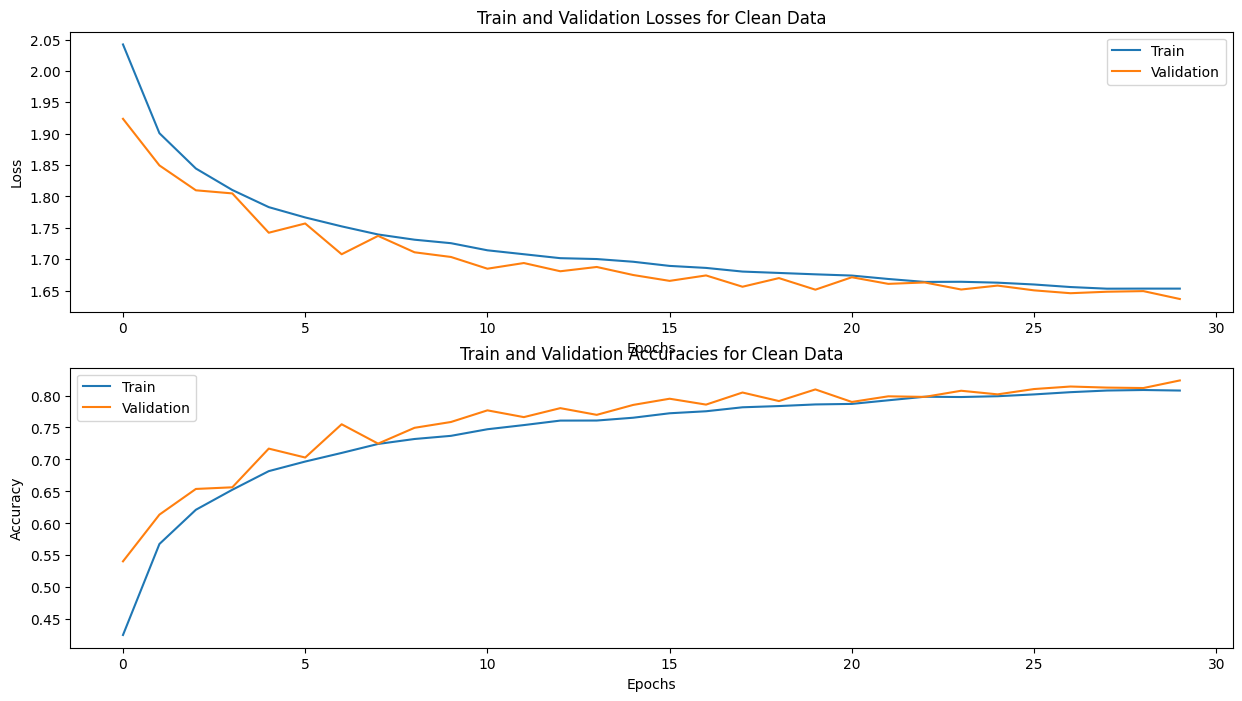

In [6]:
clean_model = NeuralModel()
clean_model.train()
clean_model.plot_history()
torch.save(clean_model, "./models/clean_model.pt")

#### 1.5.3 Loading
You can run this code block to load the pre-trained clean model.

In [28]:
clean_model = torch.load("./models/clean_model.pt")

### 1.6 Metrics

We define the metrics with which we measure the effectiveness of our attacks and defenses. These are the Attack Succes Rate (ASR), which measures how many of our adversarial samples resulted in wrongful classification, and the Clean Accuracy Drop, which measures the decrease in accuracy on a clean dataset when a clean model is fed adversarial samples.

In [26]:
def _count_non_source_misclassifications(targets: torch.Tensor, predictions: torch.Tensor, source_label, target_label):
    """Calculates and returns the number of classifications of images with a label that is not the source label nor the target label.
    
    Taken from the week 9 lab notebook (Backdoor Defenses, dr. Picek) and refactored."""
    
    sub_non_source_total = 0
    sub_misclassifications = 0
    
    sub_non_source_total_dict = {}
    sub_misclassification_dict = {}

    # Find all the images with a different label than the source or target label
    indices = torch.logical_and((targets != source_label), (targets != target_label)).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    sub_non_source_total += indices.shape[0]

    # For all non-source and non-target label images, check if the prediction is equal to the target label
    for index in indices:
        target = targets[index].detach().cpu().numpy()
        prediction = predictions[index].detach().cpu().numpy()
        
        if str(target) in sub_non_source_total_dict:
            sub_non_source_total_dict[str(target)] += 1
        else:
            sub_non_source_total_dict[str(target)] = 1
        
        if prediction == target_label:
            sub_misclassifications += 1
            
            if str(target) in sub_misclassification_dict:
                sub_misclassification_dict[str(target)] += 1
            else:
                sub_misclassification_dict[str(target)] = 1
    
    return sub_misclassifications, sub_non_source_total, sub_misclassification_dict, sub_non_source_total_dict

def _count_source_specific_classifications(targets: torch.Tensor, predictions: torch.Tensor, source_label: int, target_label: int):
    """Calculates and returns the number of classifications of images with the source label.
    
    Taken from the week 9 lab notebook (Backdoor Defenses, dr. Picek) and refactored."""
    sub_total = 0
    sub_correct = 0
    
    # Find all the images with the source label
    indices = (targets == source_label).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    sub_total += indices.shape[0]
    
    # For all source label images, check if the prediction is equal to the target label
    for i in indices:
        if predictions[i].detach().cpu().numpy() == target_label:
            sub_correct += 1
    
    return sub_correct, sub_total

def attack_success_rate(model: NeuralModel, adversarial_test_dataloader: DataLoader, target_label: int, source_label: int = None, verbose: bool = False) -> float:
    """Calculates and returns the Attack Success Rate.
    
    Taken from the week 9 lab notebook (Backdoor Defenses, dr. Picek) and refactored."""
    
    correct = 0
    total = 0
    non_source_total = 0
    misclassifications = 0
    
    non_source_total_dict = {}
    misclassification_dict = {}

    with torch.no_grad():
        model.neural_network.eval()

        for images, targets in tqdm(adversarial_test_dataloader):
            # Use poisoned test image to get predictions of backdoored model
            images = images.to(device)
            outputs = model.neural_network(images).detach()
            _, predictions = torch.max(outputs, dim=1)
            
            # If source agnostic attack
            if source_label is None:
                # For all test samples, check if the predicted label is equal to the target label
                for i in range(len(images)):
                    if targets[i] != target_label:
                        total += 1
                        
                        if predictions[i].detach().cpu().item() == target_label:
                            correct += 1
            # If source specific attack
            else:
                sub_correct, sub_total = _count_source_specific_classifications(targets, predictions, source_label, target_label)
                correct += sub_correct
                total += sub_total
                
                if verbose:
                    sub_misclassifications, sub_non_source_total, sub_misclassification_dict, sub_non_source_total_dict = _count_non_source_misclassifications(targets, predictions, source_label, target_label)
                    misclassifications += sub_misclassifications
                    non_source_total += sub_non_source_total
                    
                    for key in sub_misclassification_dict.keys():
                        if key in misclassification_dict:
                            misclassification_dict[key] += sub_misclassification_dict[key]
                        else:
                            misclassification_dict[key] = sub_misclassification_dict[key]
                            
                    for key in sub_non_source_total_dict.keys():
                        if key in non_source_total_dict:
                            non_source_total_dict[key] += sub_non_source_total_dict[key]
                        else:
                            non_source_total_dict[key] = sub_non_source_total_dict[key]
                            
        if verbose:
            for key in non_source_total_dict.keys():
                if key in misclassification_dict:
                    misclassification_dict[key] = round(misclassification_dict[key] / non_source_total_dict[key], 2)
                else:
                    misclassification_dict[key] = 0

    attack_success_rate = correct / total
    print(f"Attack Success Rate: {round(attack_success_rate, 2)}")
    
    if source_label and verbose:
        print(f"Number of Misclassifications:", misclassifications)
        print(f"Number of Images Not With Source Label:", non_source_total)
        print("Rate of Misclassification for Backdoored Images with Labels other than Source of Target:")
        
        for key, value in misclassification_dict.items():
            print(f" {key}: {value}")
        
        misclassification_rate = misclassifications / non_source_total
        print(f"False Positive Rate: {round(misclassification_rate, 2)}")
        
    return attack_success_rate

def clean_accuracy_drop(clean_model: NeuralModel, adversarial_model: NeuralModel) -> float:
    """Calculates and returns the Clean Accuracy Drop between a clean and adversarial model."""
    
    original_test_data_adversarial_model = copy(adversarial_model.test_data)
    adversarial_model.test_data = clean_model.test_data
    
    _, accuracy_clean_model = clean_model.test()
    _, accuracy_adversarial_model = adversarial_model.test()
    
    adversarial_model.test_data = original_test_data_adversarial_model
    
    clean_accuracy_drop = round(accuracy_clean_model - accuracy_adversarial_model, 2)
    print("Clean Accuracy Drop:", clean_accuracy_drop)
    
    return clean_accuracy_drop

### 1.7 Defenses
Finally, we define the defenses we want to use to protect our models from attacks.
We will define an implementation of the Fine-Pruning defense.

In [36]:
class FinePruningDefense:
    def __init__(self, model: NeuralModel, block_to_prune: nn.Sequential) -> None:
        self.model = model
        self.block_to_prune = block_to_prune
        
        self.prune_rate = 0.2
        self.finetune_epochs = int(self.model.epochs * 0.1)
        
    def prune(self) -> None:     
        print(" Pruning...")
           
        for layer in self.block_to_prune.children():            
            if type(layer) is torch.nn.modules.conv.Conv2d:
                print(f"  Pruned layer {layer}")
                
                layer = torch.nn.utils.prune.l1_unstructured(module=layer, name="weight", amount=self.prune_rate)
        
    def finetune(self) -> None:      
        print(" Finetuning...")
         
        self.model.epochs = self.finetune_epochs
        self.model.train()

## Part 2: Q&A

### 2.1 Blend Attack

#### 2.1.a 
Q: Execute a source-specific Blend attack using the hello-kitty image
on the CIFAR-10 dataset. Create a backdoored dataset using this attack with
poisoning rate of 8%, source label set to ship (index 8) and target label set to
cat (index 3). Compute and report the Attack Succes Rate (ASR) and Clean
Accuracy Drop (CAD). Save the dataset and model for later use. Evaluate the
performance of the attack and share your conclusions.

In [8]:
blend_attack = BlendAttack(source_label=8, target_label=3)
backdoored_model = NeuralModel(attack=blend_attack)
backdoored_model.train()
backdoored_model.plot_history()
torch.save(backdoored_model, "./models/blend_model.pt")

gc.collect()

KeyboardInterrupt: 

100%|██████████| 79/79 [01:28<00:00,  1.12s/it] 


Attack Success Rate: 0.61
Number of Misclassifications: 801
Number of Images Not With Source Label: 8000
False Positive Rate: 0.1
 Testing...


100%|██████████| 79/79 [00:03<00:00, 21.24it/s]


 Testing...


100%|██████████| 79/79 [00:03<00:00, 21.80it/s]


Clean Accuracy Drop: 0.02


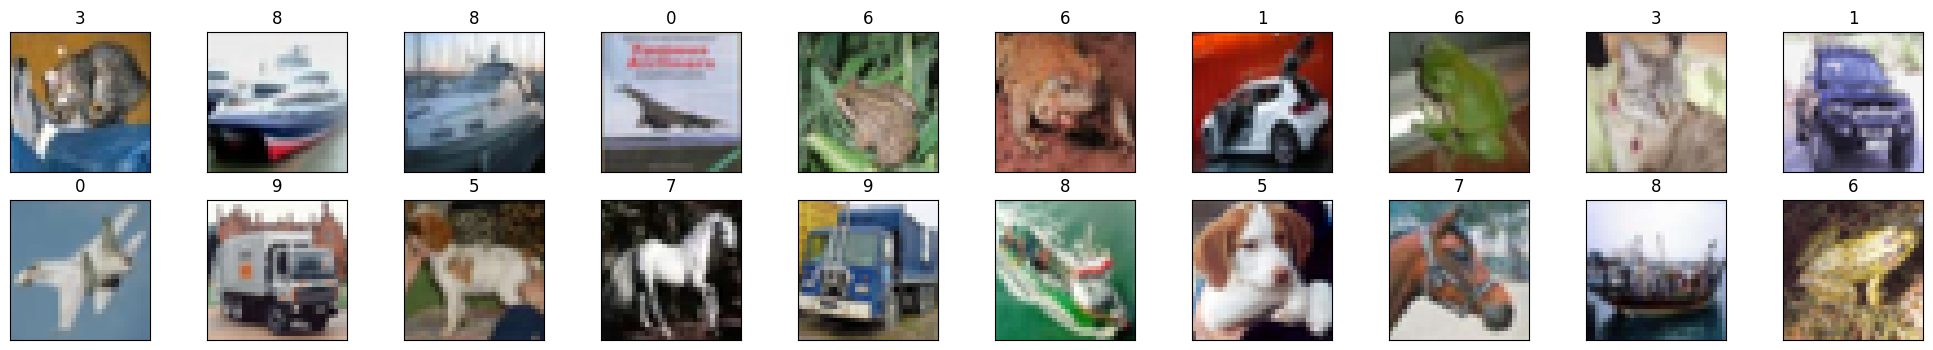

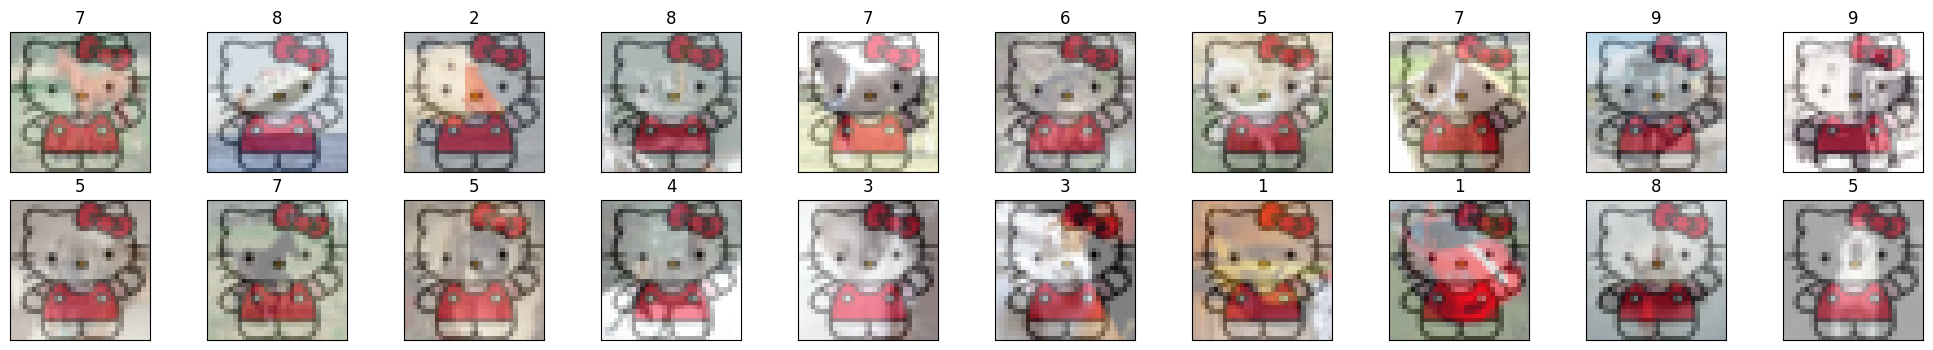

67593

In [ ]:
backdoored_model = torch.load("./models/blend_model.pt")

attack_success_rate(model=backdoored_model, adversarial_test_dataloader=backdoored_model.test_data, source_label=8, target_label=3)
clean_accuracy_drop(clean_model=clean_model, adversarial_model=backdoored_model)

images, labels = next(iter(clean_model.test_data))
visualize_batch(images, labels)

images, labels = next(iter(backdoored_model.test_data))
visualize_batch(images, labels)

gc.collect()

A: The attack has been quite successful. The backdoored model has an Attack Success Rate of 0.61/61%, while only suffering from a small Clean Accuracy Drop of 0.02/2% when compared to the clean model. This means that our backdoored model performs practically on-par with the clean model, while classifying backdoored images of ships as cats for the majority of predictions. Although our model is far from perfectly backdoored, I would conclude that the backdoor is quite successful.

#### 2.1.b 
Q: With the source specific attack, the attacker’s goal is to let the input
be missclassified to the target label only when the input has a specific source
label. However, we also poison other images. Why do we do this? For every
other label (so not source or target), report the percentage of samples in the test
set that are now, because of the attack, also missclassified with the target label.

In [ ]:
attack_success_rate(model=backdoored_model, adversarial_test_dataloader=backdoored_model.test_data, source_label=8, target_label=3, verbose=True)

100%|██████████| 79/79 [00:02<00:00, 30.55it/s]

Attack Success Rate: 0.61
Number of Misclassifications: 801
Number of Images Not With Source Label: 8000
Rate of Misclassification for Labels other than Source of Target:
 2: 0.12
 5: 0.23
 7: 0.08
 6: 0.04
 0: 0.12
 9: 0.09
 4: 0.06
 1: 0.07
False Positive Rate: 0.1


0.606

A: We poison images without the source label in source-specific backdoor attacks, because that makes the backdoored dataset more natural. If we only backdoored images with the source label we chose, then only one class of images would have been backdoored. If a backdoor can be noticed by a defender, especially visually, and it only occurs for one specific class of images, then the defender can quite easily pick up on the fact that the training data has been backdoored. By backdooring images with other labels, the distribution of backdoored images fits the original data's distribution better, which may make it seem that the backdoor is actually a natural element of the dataset.

As we can see from the results, backdoored images of all labels othet than the source and target label suffer from at least some degree of misclassification to the target label. For most classes, the misclassification rate is between 0.05/5% and 0.10/10%. However, classes 0 (airplane) and 2 (bird) have a 0.12/12% misclassification rate, and class 5 (dog) even has a misclassification rate of 0.23/23%. 

### 2.2 WaNet Attack

#### 2.2.a
Q: Execute a source-agnostic WaNet attack on the CIFAR-10 dataset.
Create a backdoored dataset using this attack with the following parameters:
- k = 8
- s = 1
- poisoning rate = 8%
- target label = cat (index 3)
- mode = attack. Use the attack mode and not the noise mode as described in the WaNet paper. More specific, use a cross ratio of 0.
- attack mode = all to one. So one specific target class.
- grid rescale = 1

Compute and report the Attack Succes Rate (ASR) and Clean Accuracy Drop
(CAD). Evaluate the performance of the attack and share your conclusions.

Files already downloaded and verified


c:\Users\Daan\Documents\Projecten\ru-security-and-privacy-of-machine-learning-23-24\env\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\Daan\Documents\Projecten\ru-security-and-privacy-of-machine-learning-23-24\env\Lib\site-packages\torch\nn\functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:18<00:00, 16.68it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 56.76it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:17<00:00, 18.20it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 55.24it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.92it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 54.33it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:18<00:00, 16.76it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 49.65it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.41it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 49.13it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.03it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.64it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.53it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.34it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.06it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.33it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.82it/s]


Started Epoch 11
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.34it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.22it/s]


Started Epoch 12
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.35it/s]


Started Epoch 13
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.42it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.75it/s]


Started Epoch 14
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.54it/s]


Started Epoch 15
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.39it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.10it/s]


Started Epoch 16
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.39it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.64it/s]


Started Epoch 17
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.38it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.55it/s]


Started Epoch 18
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.42it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.58it/s]


Started Epoch 19
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.39it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.25it/s]


Started Epoch 20
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.39it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.67it/s]


Started Epoch 21
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.32it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.45it/s]


Started Epoch 22
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.32it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.45it/s]


Started Epoch 23
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.31it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 50.64it/s]


Started Epoch 24
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.31it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 49.37it/s]


Started Epoch 25
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 49.94it/s]


Started Epoch 26
 Training...


100%|██████████| 313/313 [00:18<00:00, 16.72it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 54.75it/s]


Started Epoch 27
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.47it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 52.88it/s]


Started Epoch 28
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.61it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 55.26it/s]


Started Epoch 29
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.50it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 53.59it/s]


Started Epoch 30
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.57it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 53.85it/s]


0

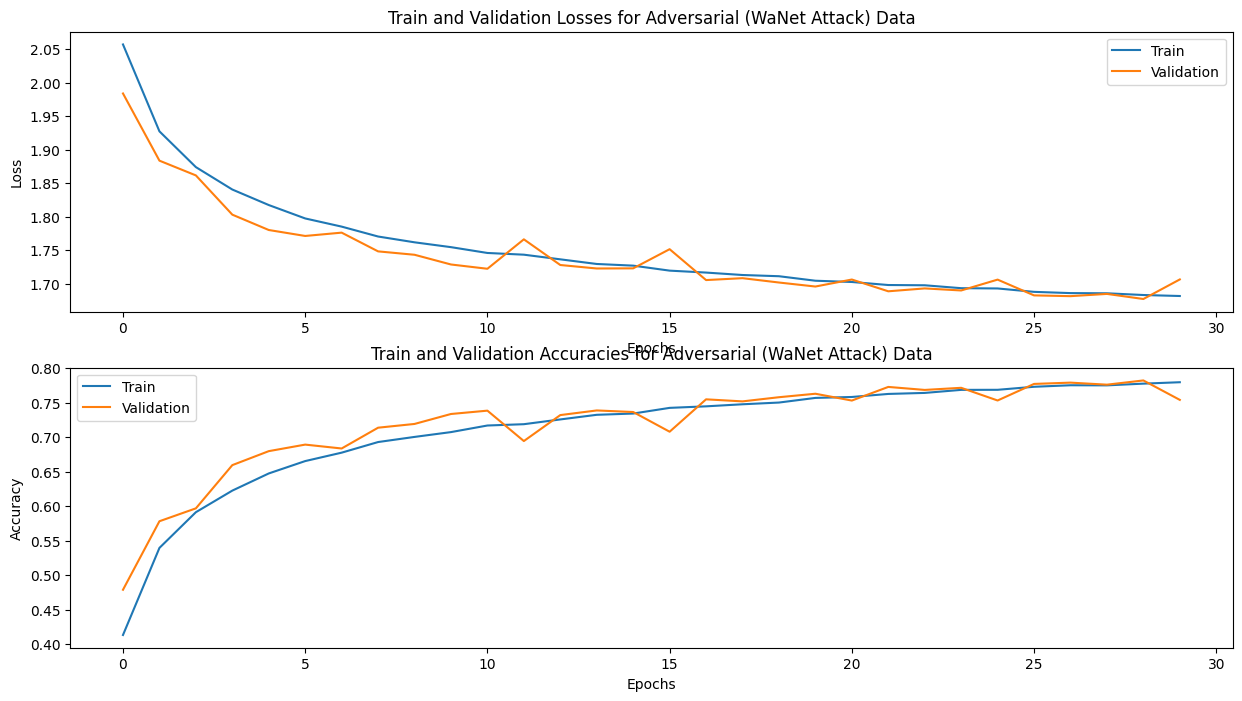

In [ ]:
wanet_attack = WaNetAttack(source_label=None, target_label=3)
backdoored_model = NeuralModel(attack=wanet_attack)
backdoored_model.train()
backdoored_model.plot_history()
torch.save(backdoored_model, "./models/wanet_model.pt")

gc.collect()

In [ ]:
backdoored_model = torch.load("./models/wanet_model.pt")

attack_success_rate(model=backdoored_model, adversarial_test_dataloader=backdoored_model.test_data, source_label=None, target_label=3)
clean_accuracy_drop(clean_model=clean_model, adversarial_model=backdoored_model)

gc.collect()

100%|██████████| 79/79 [00:02<00:00, 28.66it/s]


Attack Success Rate: 0.69
 Testing...


100%|██████████| 79/79 [00:03<00:00, 20.49it/s]


 Testing...


100%|██████████| 79/79 [00:03<00:00, 24.79it/s]


Clean Accuracy Drop: 0.07


18

A: The WaNet attack's performance is similar to the Blend attack's performance. The WaNet backdoor results in a 0.69/69% Attack Success Rate and a Clean Accuracy Drop of 0.07/7%. On one hand, the attack is more effective, but it has also caused a much drop in clean accuracy than the Blend attack, to the point where it might be noticeably worse. I would consider the backdoor itself a success, but at the cost of a bit of the model's accuracy.

#### 2.2.b
Q: Apply the WaNet attack using the settings above to generate just one
or a few poisoned images. Plot/display them. What can an attacker do to make
this attack stealthier? In your answer, explain what the parameters k and s
stand for and what they are used for.

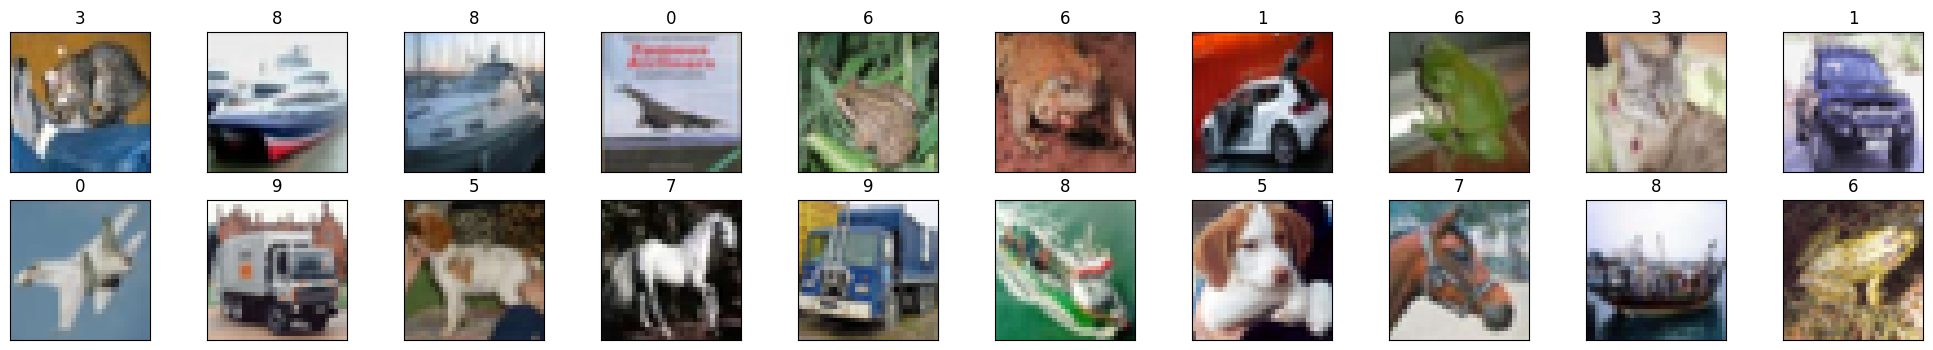

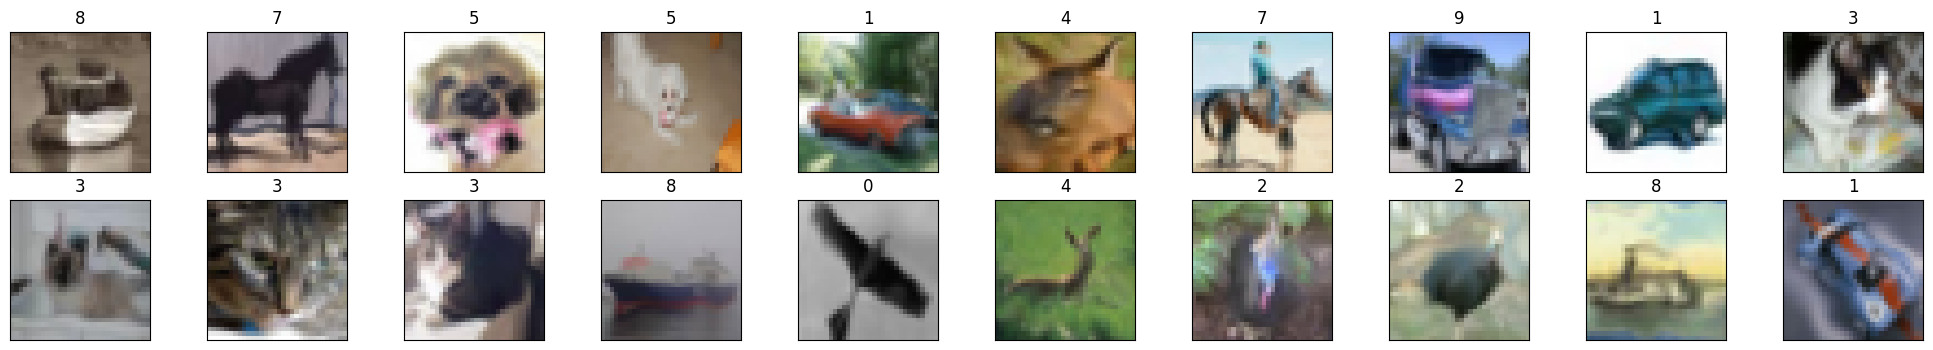

67584

In [ ]:
images, labels = next(iter(clean_model.test_data))
visualize_batch(images, labels)

images, labels = next(iter(backdoored_model.test_data))
visualize_batch(images, labels)

gc.collect()

A: To make the attack stealthier, the attacker could reduce the values for the hyperparameters $k$ and $s$. These are currently at a high or max value. Reducing the values of these hyperparameters reduces the visual effect of the attack on the images, but possibly at the cost of the ASR. Specifically, reducing $s \in [0, 1]$ would reduce the strength of the warping effect. It is currently 1, meaning that the warping effect of the WaNet attack is applied with full strength. Reducing the value of $s$ reduces the severity of the warping, which makes it less noticeable. Reducing $k$ reduces the size of the random noise space that is used to generate the final warping field, which reduces the variety and the number of changes applied to the image, making the attack harder to notice.

### 2.3 Fine-Pruning Defense

#### 2.3.a
Q: Execute the Fine-pruning defense on your source specific blend backdoored model from Question 1. Use a pruning rate of 20% and fine-tune your
model for 10% of the total number of epochs you initially trained your model.
You are free to decide which layer you prune neurons from. Report the ASR
and CAD directly after pruning and also after the fine-tuning part. Evaluate
the performance of the defense and share your conclusions.

In [37]:
backdoored_model = torch.load("./models/blend_model.pt")
backdoored_model.epochs = 30# TODO: REMOVE

fine_pruning_defense = FinePruningDefense(model=backdoored_model, block_to_prune=backdoored_model.neural_network.convolutional_block_3)

fine_pruning_defense.prune()
attack_success_rate(model=backdoored_model, adversarial_test_dataloader=backdoored_model.test_data, source_label=8, target_label=3)
clean_accuracy_drop(clean_model=clean_model, adversarial_model=backdoored_model)

fine_pruning_defense.finetune()
attack_success_rate(model=backdoored_model, adversarial_test_dataloader=backdoored_model.test_data, source_label=8, target_label=3)
clean_accuracy_drop(clean_model=clean_model, adversarial_model=backdoored_model)

gc.collect()

 Pruning...
  Pruned layer Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  Pruned layer Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 79/79 [00:01<00:00, 49.49it/s]


Attack Success Rate: 0.61
 Testing...


100%|██████████| 79/79 [00:03<00:00, 21.62it/s]


 Testing...


100%|██████████| 79/79 [00:03<00:00, 21.02it/s]


Clean Accuracy Drop: 0.02
 Finetuning...
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.77it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 54.59it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.76it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 54.90it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.83it/s]


 Validating...


100%|██████████| 79/79 [00:01<00:00, 54.94it/s]


Attack Success Rate: 0.28
 Testing...


100%|██████████| 79/79 [00:03<00:00, 23.04it/s]


 Testing...


100%|██████████| 79/79 [00:03<00:00, 22.74it/s]


Clean Accuracy Drop: 0.01


18

A: The defense seems to improve the backdoored model. After applying pruning, the model achieves the same ASR (0.61) and CAD (0.02) as before, meaning that pruning has not decreased its clean accuracy. Furthermore, after finetuning the pruned model, it achieves an ASR of 0.28/28% and a CAD of 0.01/1%. This means that after fine-pruning, the model has become more resilient to Blend attacks, having more than halved the ASR, and even reduced the CAD, meaning that it has a better clean accuracy than before. Since the fine-pruning strategy has decreased ASR, while maintaining CAD, I would consider the fine-pruning defense a success.

#### 2.3.b
Q: Lets say you have a simple CNN with 3 convolutional layers: conv1,
conv2, conv3. They follow each other in this precise order. You want to apply
the Fine-Pruning defense on this model. What layer will be the best candidate
to prune and why?

A: The best candidate layer to prune is most often the final convolution layer, so conv3. This is because deeper convolution layers most often learn the most features. Early convolution layers mostly learn basic features that are benign, but the deeper a layer is, and especially the more channels it has, the more likely it is that some channels/features are specialized in capturing information about the backdoor. Pruning the final layer would then mean removing channels/features dedicated to the backdoor, reducing the backdoor's effect.